In [50]:
import os
import glob
import json
import pickle

import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from datetime import datetime

from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

sns.set_palette("Set2")

sns.set_style(style='white')

In [53]:
src_results = "../../Echo-chamber-stability/results/reddit_results/"

categories = ["guncontrol", 'minority', "politics"]
semesters = [('01/01/2017','01/07/2017'), ('01/07/2017','01/01/2018'),
             ('01/01/2018','01/07/2018'), ('01/07/2018','01/01/2019'), ('01/01/2019','01/07/2019')]

jaccard = lambda x, y:  len(set(x) & set(y)) / len(set(x) | set(y))

In [31]:
with open("../results/matches_dict.pickle", 'rb') as input_file:
    matches = pickle.load(input_file)

In [54]:
matches = defaultdict(list)
for topic in tqdm(categories):
    #etichetta del semestre per ogni categoria 
    sem = 0
    print(topic)
    lifecycle = []
    for i in range(5):
        if i != 4:
            # find all users in common between adjacent semesters
            df_t0 = pd.read_csv(f"../../Echo-chamber-stability/results/reddit_results/{topic}/eva_users_merged_{i}_com_stats.csv")
            df_t1 = pd.read_csv(f"../../Echo-chamber-stability/results/reddit_results/{topic}/eva_users_merged_{i+1}_com_stats.csv")
            user_list_t0 = df_t0.user_id.tolist()
            user_list_t1 = df_t1.user_id.tolist()
            # we only keep users that are in both semesters to avoid biases
            intersection = [user for user in user_list_t0 if user in user_list_t1]
            df_t0_clean = df_t0[df_t0["user_id"].isin(intersection)]
            df_t1_clean = df_t1[df_t1["user_id"].isin(intersection)]
            dict_com = defaultdict(list)
            dict_com_t1 = defaultdict(list)
            # create a dictionary to assign each community to the list of users inside it
            for com in df_t0_clean.community.unique():
                com_df = df_t0_clean[df_t0_clean["community"]== com]
                dict_com[com] = com_df.user_id.tolist()
            for com in df_t1_clean.community.unique():
                com_df = df_t1_clean[df_t1_clean["community"]== com]
                dict_com_t1[com] = com_df.user_id.tolist() 
            # find the best match between communities and calculate communities' lifecycle
            for name_i, com_i in dict_com.items():
                best_match = []
                best_score = 0
                for name_j, com_j in dict_com_t1.items():
                    match = jaccard(com_i, com_j)
                    if match > best_score:
                        best_match = [name_j]
                        best_score = match
                    elif match == best_score:
                        best_match.append(name_j)
                for j in best_match:
                    lifecycle.append((name_i, j, best_score))
                    
        matches[topic] = lifecycle
        

  0%|          | 0/3 [00:00<?, ?it/s]

guncontrol
minority
politics


In [87]:
def temporal_stability(community, topic):
    actual_com = community
    for i in range(len(matches[topic])):
        # the list stability will contain the jaccard scores for all the adjacent timestamp in the lifecycle
        stability = []
        plot_labels = []
        #  timeline contains the ids of the communities
        timeline =[]
        if matches[topic][i][0] == actual_com: # extract jaccard similarity for the first community in the lifecycle
            stability.append(matches[topic][i][2]) # append the jaccard score
            actual_com = matches[topic][i][1] # move to the next community in the lifecycle
            timeline.append(community)
            timeline.append(actual_com)
            j = i + 1
            while j <= len(matches[topic])-1:
                if (matches[topic][j][0] == actual_com):
                    stability.append(float(matches[topic][j][2]))
                    actual_com = matches[topic][j][1]
                    timeline.append(actual_com)
                j += 1
                
            return stability, timeline
           

def ec_marker(timeline, ec_val): 
    marker_dict = {}
    for com in timeline:
        if (com in ec_val):
            marker_dict[com] = '^'
        else:
            marker_dict[com] = '.'
    return marker_dict
    
def get_marker(marker_dict, point_list):
    marker = []
    for point in point_list: 
        marker.append(marker_dict[point])
    return marker[:-1]

def get_labels(timeline):
    labels = []
    for el in range(len(timeline)-1):
        label = ' - '.join([timeline[el], timeline[el+1]])
        labels.append(label)
    return labels

In [106]:
def plot_EC_stability_topic(categories, ec_val):
    for topic in tqdm(categories):
        print("Current topic: ", topic)
        df_list = list()
       # df_users = list()
        df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
        df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))

        #retrieve non_ecs or ecs    
        df["topic"] = topic
        df = df[df["size"] >= 20].copy()
        
        #which is the stability of communities ECs?  
        fig, ax = plt.subplots(1,1,figsize=(13,7))
        communities = df.community.tolist()
        ec_coms = df_ec.community.tolist()
        tot_coms = communities + ec_coms
        for com in tot_coms:
            #if com.startswith('0'):
            if not com.startswith('4'):
                # the coms labels at t0 are the input for temporal_stability () 
                stability, timeline = temporal_stability(com, topic) # are ECs stable over time?
                plot_stab = stability

                # necessary to plot all the communities
                if len(plot_stab)<4:
                    while len(plot_stab)<4:
                        plot_stab.insert(0,np.nan)
                marker_dict = ec_marker(timeline, ec_coms)
                marker_list = get_marker(marker_dict, timeline)
                if len(marker_list)<4:
                    while len(marker_list)<4:
                        marker_list.insert(0,"none")
                                
                # matplotlib plot
                plt.plot(stability,zorder=-1, linewidth=2.5, alpha = 0.5, c = "#bababa")
                for i in range(0,len(stability)):
                    if marker_list[i] == ".":
                        ax.scatter(i, stability[i], 
                                   marker='.', label='Not-EC', s = 600, alpha = 0.7, c="#bcbd22")
                    if marker_list[i] == "^":
                        ax.scatter(i, plot_stab[i], 
                                   marker='^', label="EC", alpha = 0.7, s = 300, c="#ff7f0e")
                triangle = mlines.Line2D([], [], alpha = 0.4, color='#ff7f0e', marker='^',
                          markersize=25, label='EC')
                dot = mlines.Line2D([], [], alpha = 0.4, color='#bcbd22', marker='.',
                          markersize=28, label= 'Not-EC')
                ax.legend(handles=[triangle, dot], prop={'size': 18},  fontsize=28, loc = "lower right")
            ax.set_ylim(ymin=-0.1, ymax=1)
            ax.set_xticks([0, 1, 2, 3],
                        ["01/17-07/17\n07/17-01/18", "07/17-01/18\n01/18-07/18",
                        "01/18-07/18\n07/18-01/19", "07/18-01/19\n01/19-07/19"],
                        fontsize=18)
            if topic == "minority":
                label = "Minorities discrimination" 
            elif topic == "guncontrol":
                label = "Gun control"   
            else:
                label = str(topic).capitalize()
            plt.title(label, fontsize=28)
            plt.ylabel('Jaccard similarity', labelpad= 15, fontsize=22)
            # plt.xlabel('Community evolution', labelpad = 15, fontsize=22)
            plt.yticks(fontsize = 18)
            plt.ylim(ymin=0, ymax = 1)  
            plt.tight_layout()
            
        plt.savefig(F"../plot/EC_stability/{ec_val}_stability_{topic}.png", dpi=300)


  0%|          | 0/3 [00:00<?, ?it/s]

Current topic:  guncontrol
Current topic:  minority
Current topic:  politics


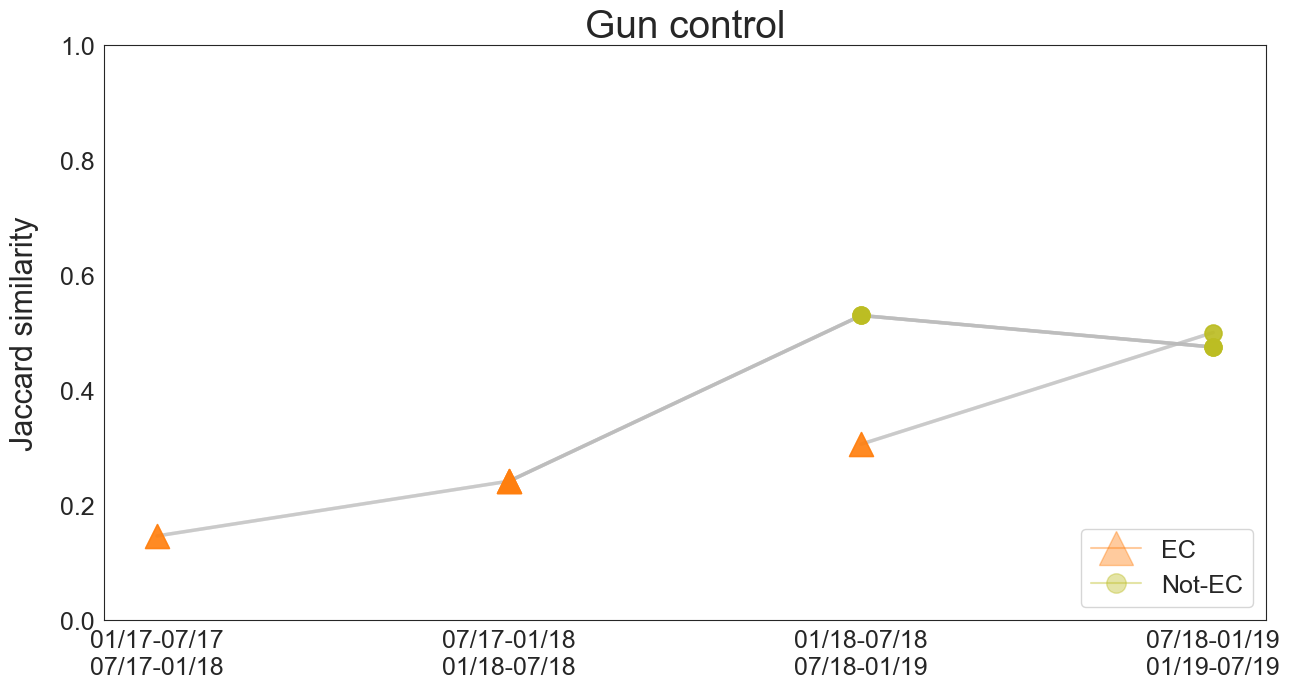

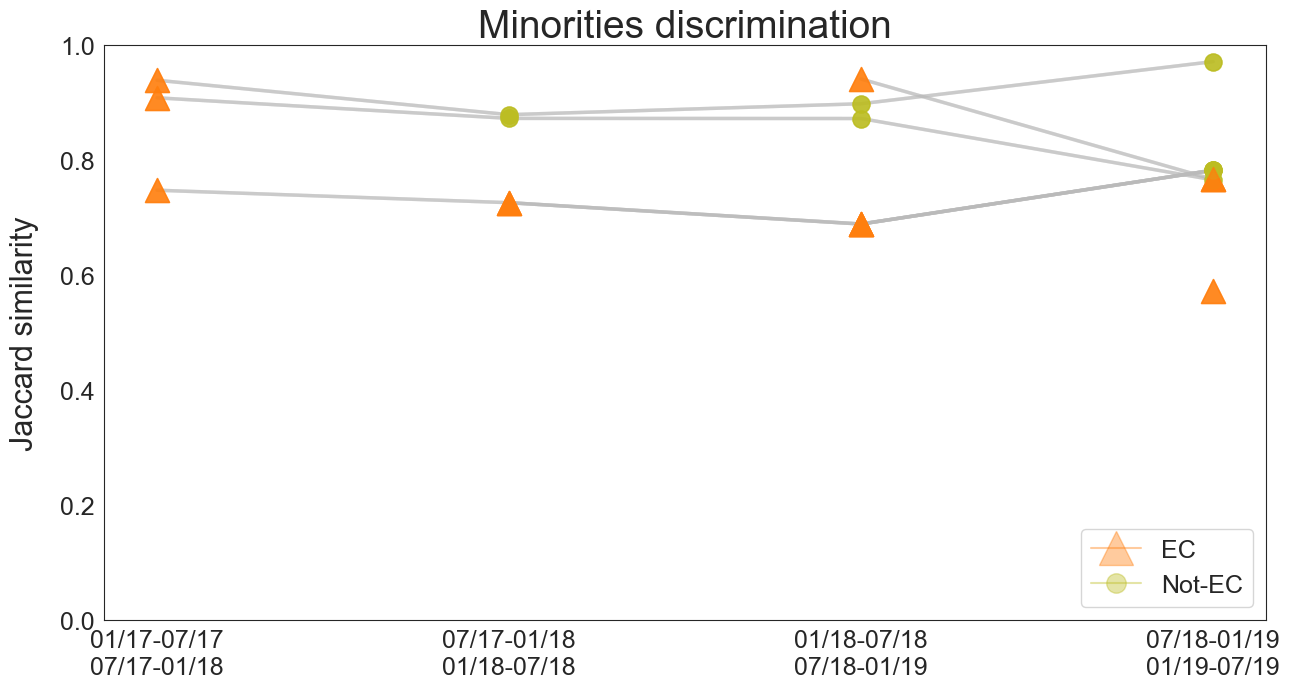

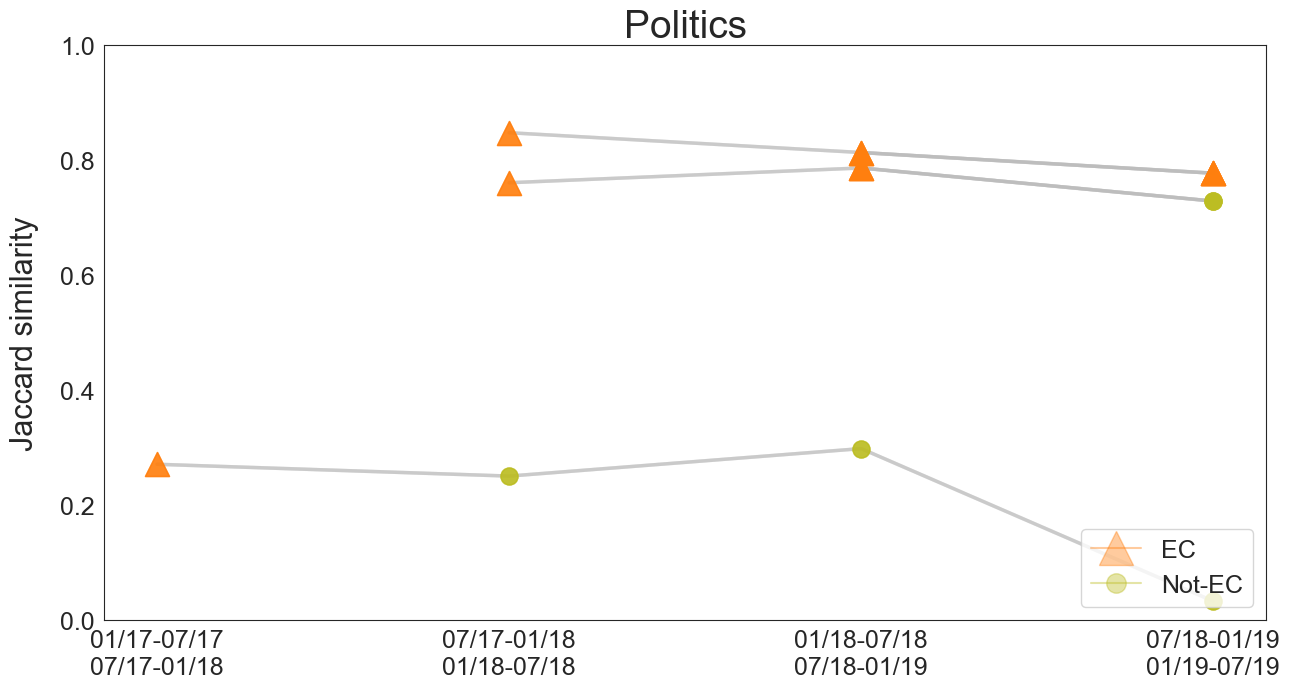

In [107]:
plot_EC_stability_topic(categories, "EC")


  0%|          | 0/3 [00:00<?, ?it/s]

Current topic:  guncontrol
Current topic:  minority
Current topic:  politics


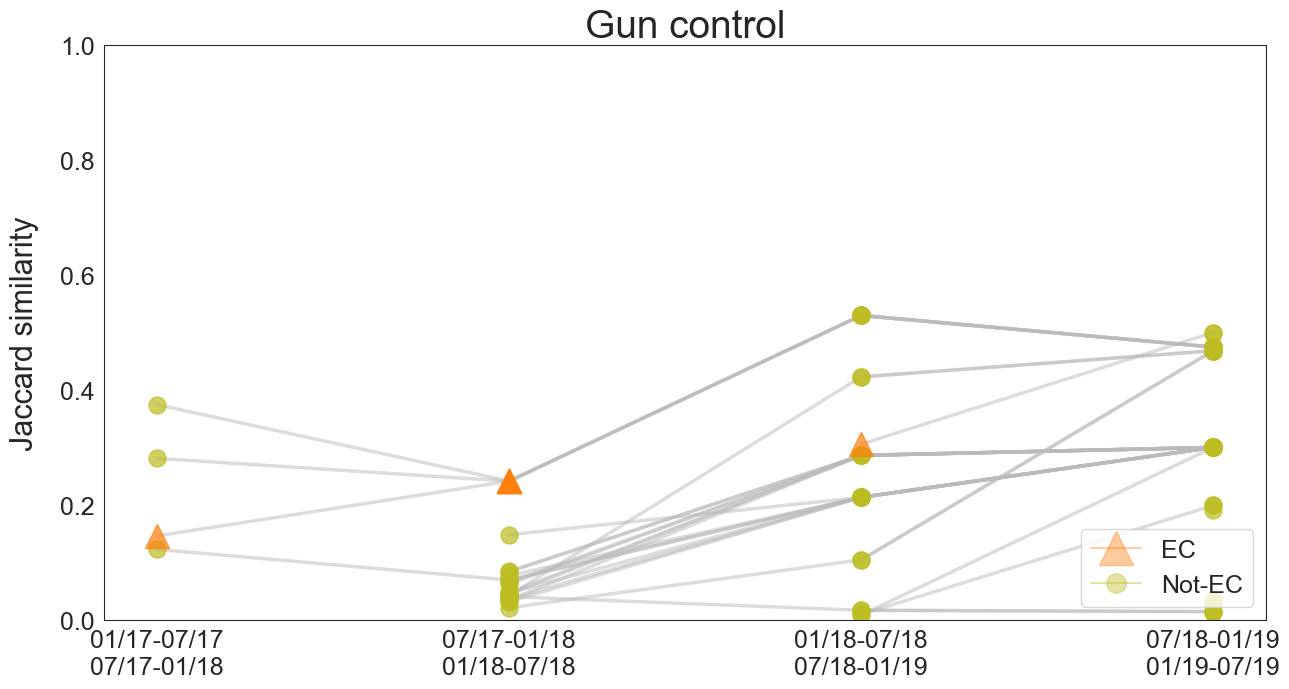

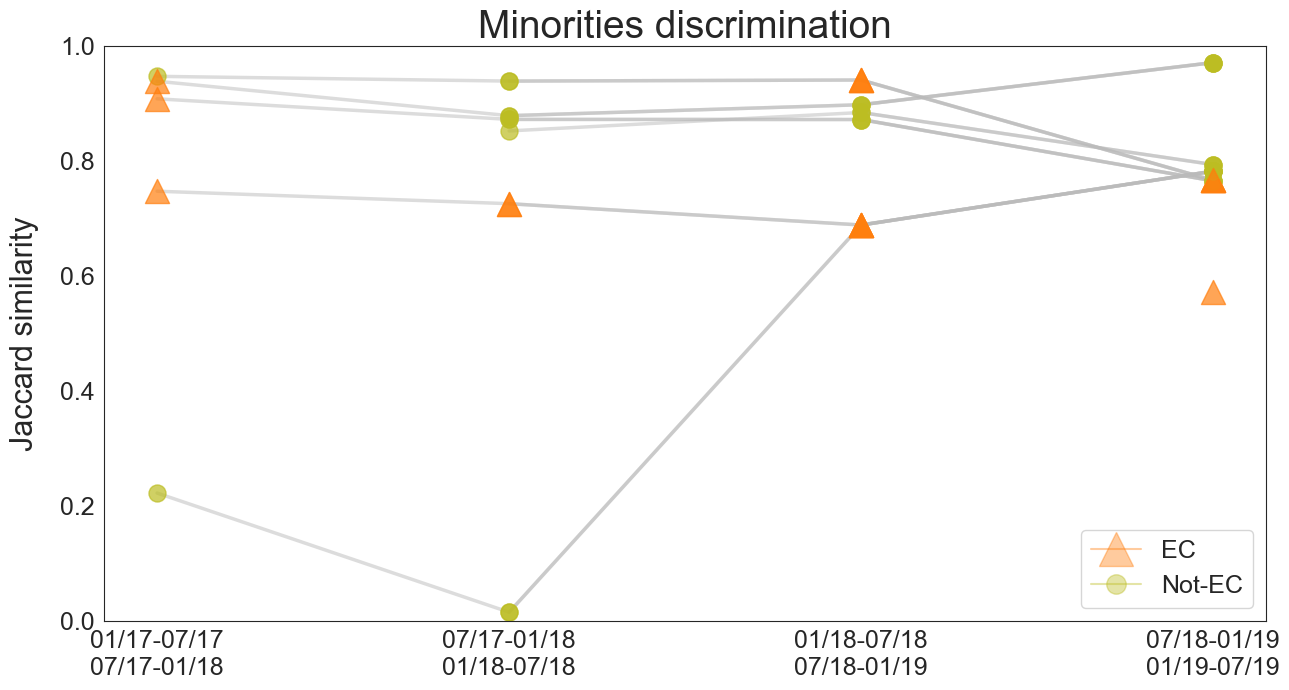

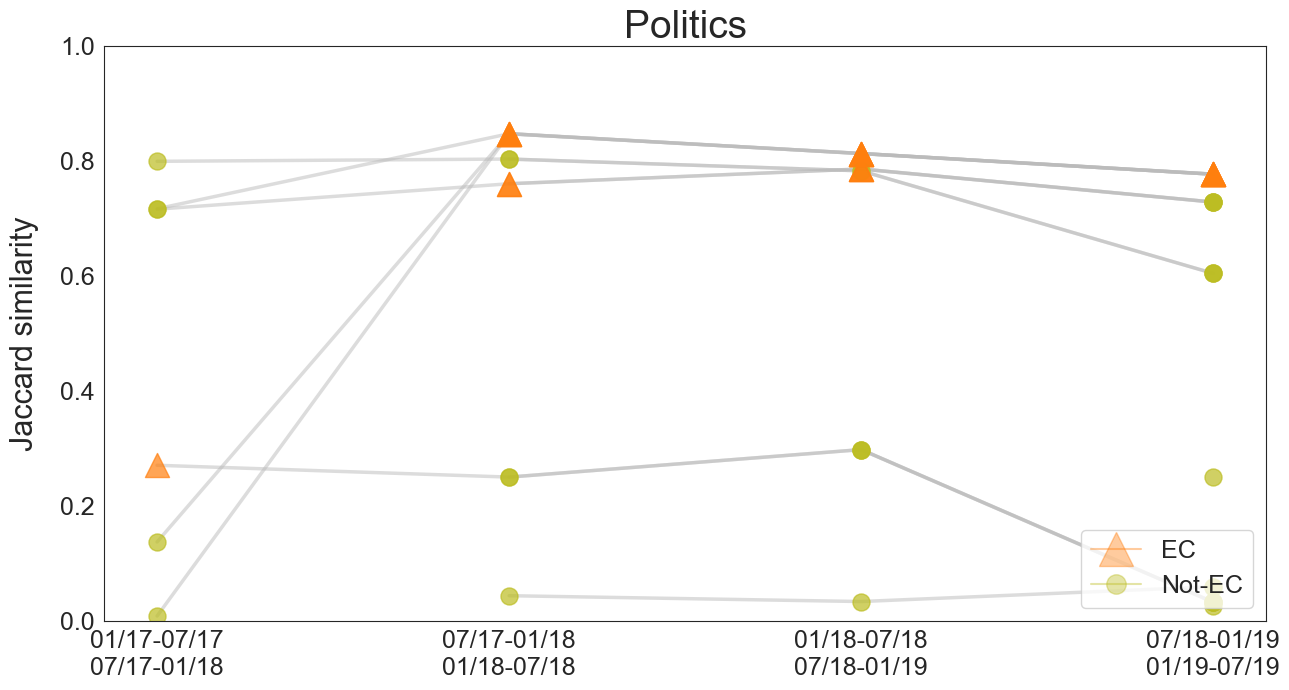

In [93]:
plot_EC_stability_topic(categories, "not_EC")


In [96]:
# change font for the plot labels
csfont = {'fontname':'Times New Roman'}


In [110]:
def unique_plot_stability(categories, ec_val):
    fig, axes = plt.subplots(len(categories), 1, figsize=(12, 20))
    labels = ['a)', 'b)', 'c)']  # Labels for the plots
    fig.text(-0.00009, 0.5, 'Jaccard similarity', va='center', rotation='vertical', fontsize=22, ha='center') #y-axis label

    for i, topic in tqdm(enumerate(categories)):
        ax = axes[i]
        df_list = list()
        df = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_{ec_val}_{topic}.csv"))
        df_ec = pd.read_csv(os.path.join(src_results, f"{topic}/df_complete_ec_{topic}.csv"))

        #retrieve not_ecs or ecs    
        df["topic"] = topic
        df = df[df["size"] >= 20].copy() # we keep only communities with at least 20 users
        communities = df.community.tolist()
        ec_coms = df_ec.community.tolist()
        tot_coms = communities + ec_coms
        for com in tot_coms:
            if not com.startswith('4'):
                stability, timeline = temporal_stability(com, topic)
                plot_stab = stability
                if len(plot_stab)<4:
                    while len(plot_stab)<4:
                        plot_stab.insert(0, np.nan)
                        
                marker_dict = ec_marker(timeline, ec_coms)
                marker_list = get_marker(marker_dict, timeline)
                if len(marker_list)<4:
                    while len(marker_list)<4:
                        marker_list.insert(0,"none")
                
                timeline_labels = get_labels(timeline)
                
                ax.plot(stability, zorder=-1, linewidth=2.5, alpha=0.5, c="#bababa")
                for l in range(0, len(stability)):
                    if marker_list[l] == ".":
                        ax.scatter(l, stability[l], marker='.', label='Not-EC', s=600, alpha=0.7, c="#bcbd22")
                    if marker_list[l] == "^":
                        ax.scatter(l, plot_stab[l], marker='^', label="EC", alpha=0.7, s=300, c="#ff7f0e")
                ax.set_ylim(ymin=-0.1, ymax=1)
                ax.set_xticks([0, 1, 2, 3],
                            ["01/17-07/17\n07/17-01/18", "07/17-01/18\n01/18-07/18",
                            "01/18-07/18\n07/18-01/19", "07/18-01/19\n01/19-07/19"],
                            fontsize=18)
                if topic == "minority":
                    label = "Minorities discrimination" 
                elif topic == "guncontrol":
                    label = "Gun control"   
                else:
                    label = str(topic).capitalize()
                ax.set_xlabel(str(labels[i]+" "+ label),style="italic", labelpad=15, fontsize=18, **csfont) 
    plt.tight_layout()
    plt.savefig(f"../plot/EC_stability/{ec_val}_stability_plot.png", dpi=300)

0it [00:00, ?it/s]

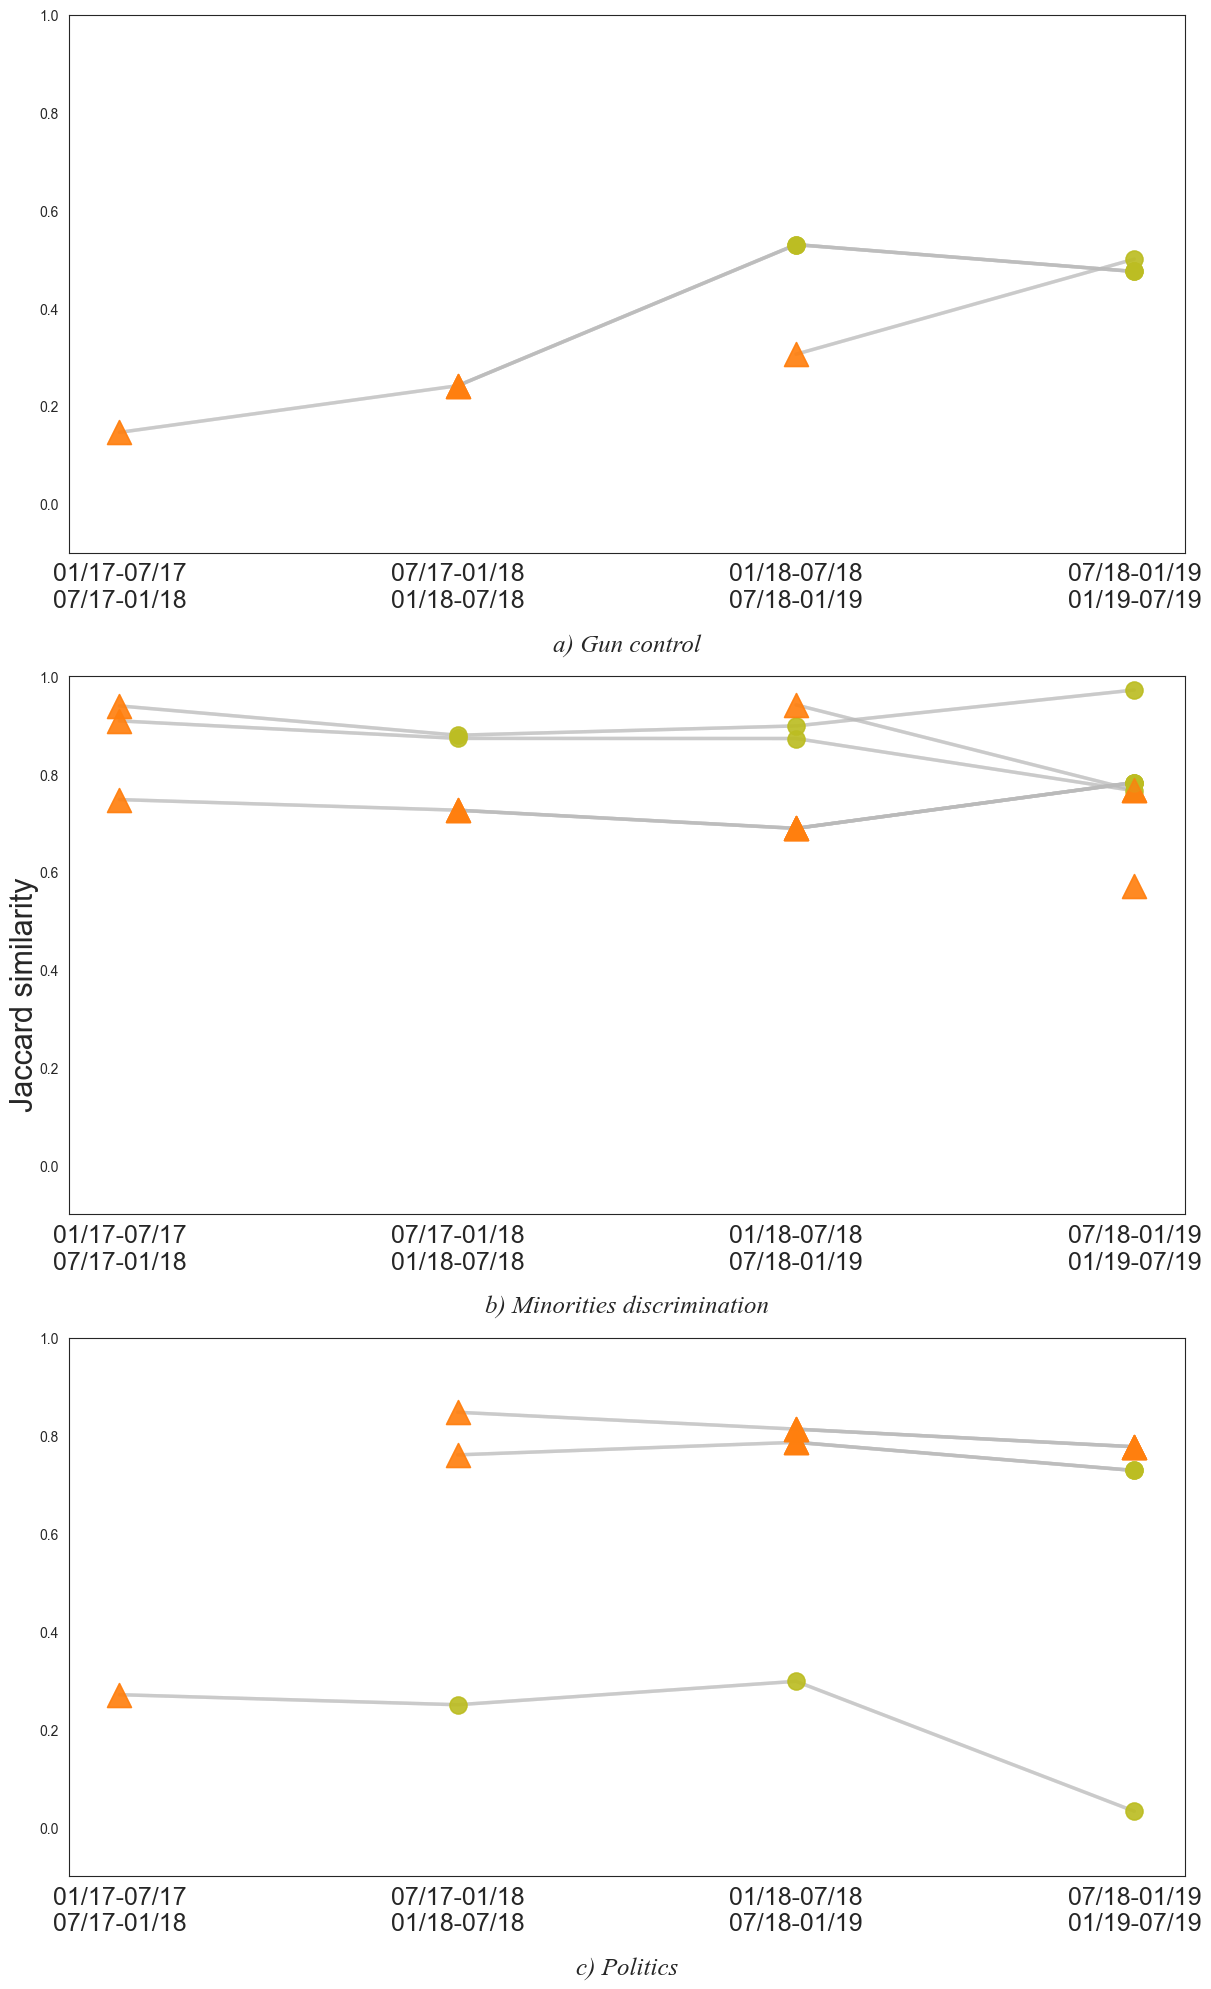

In [111]:
unique_plot_stability(categories, "EC")

0it [00:00, ?it/s]

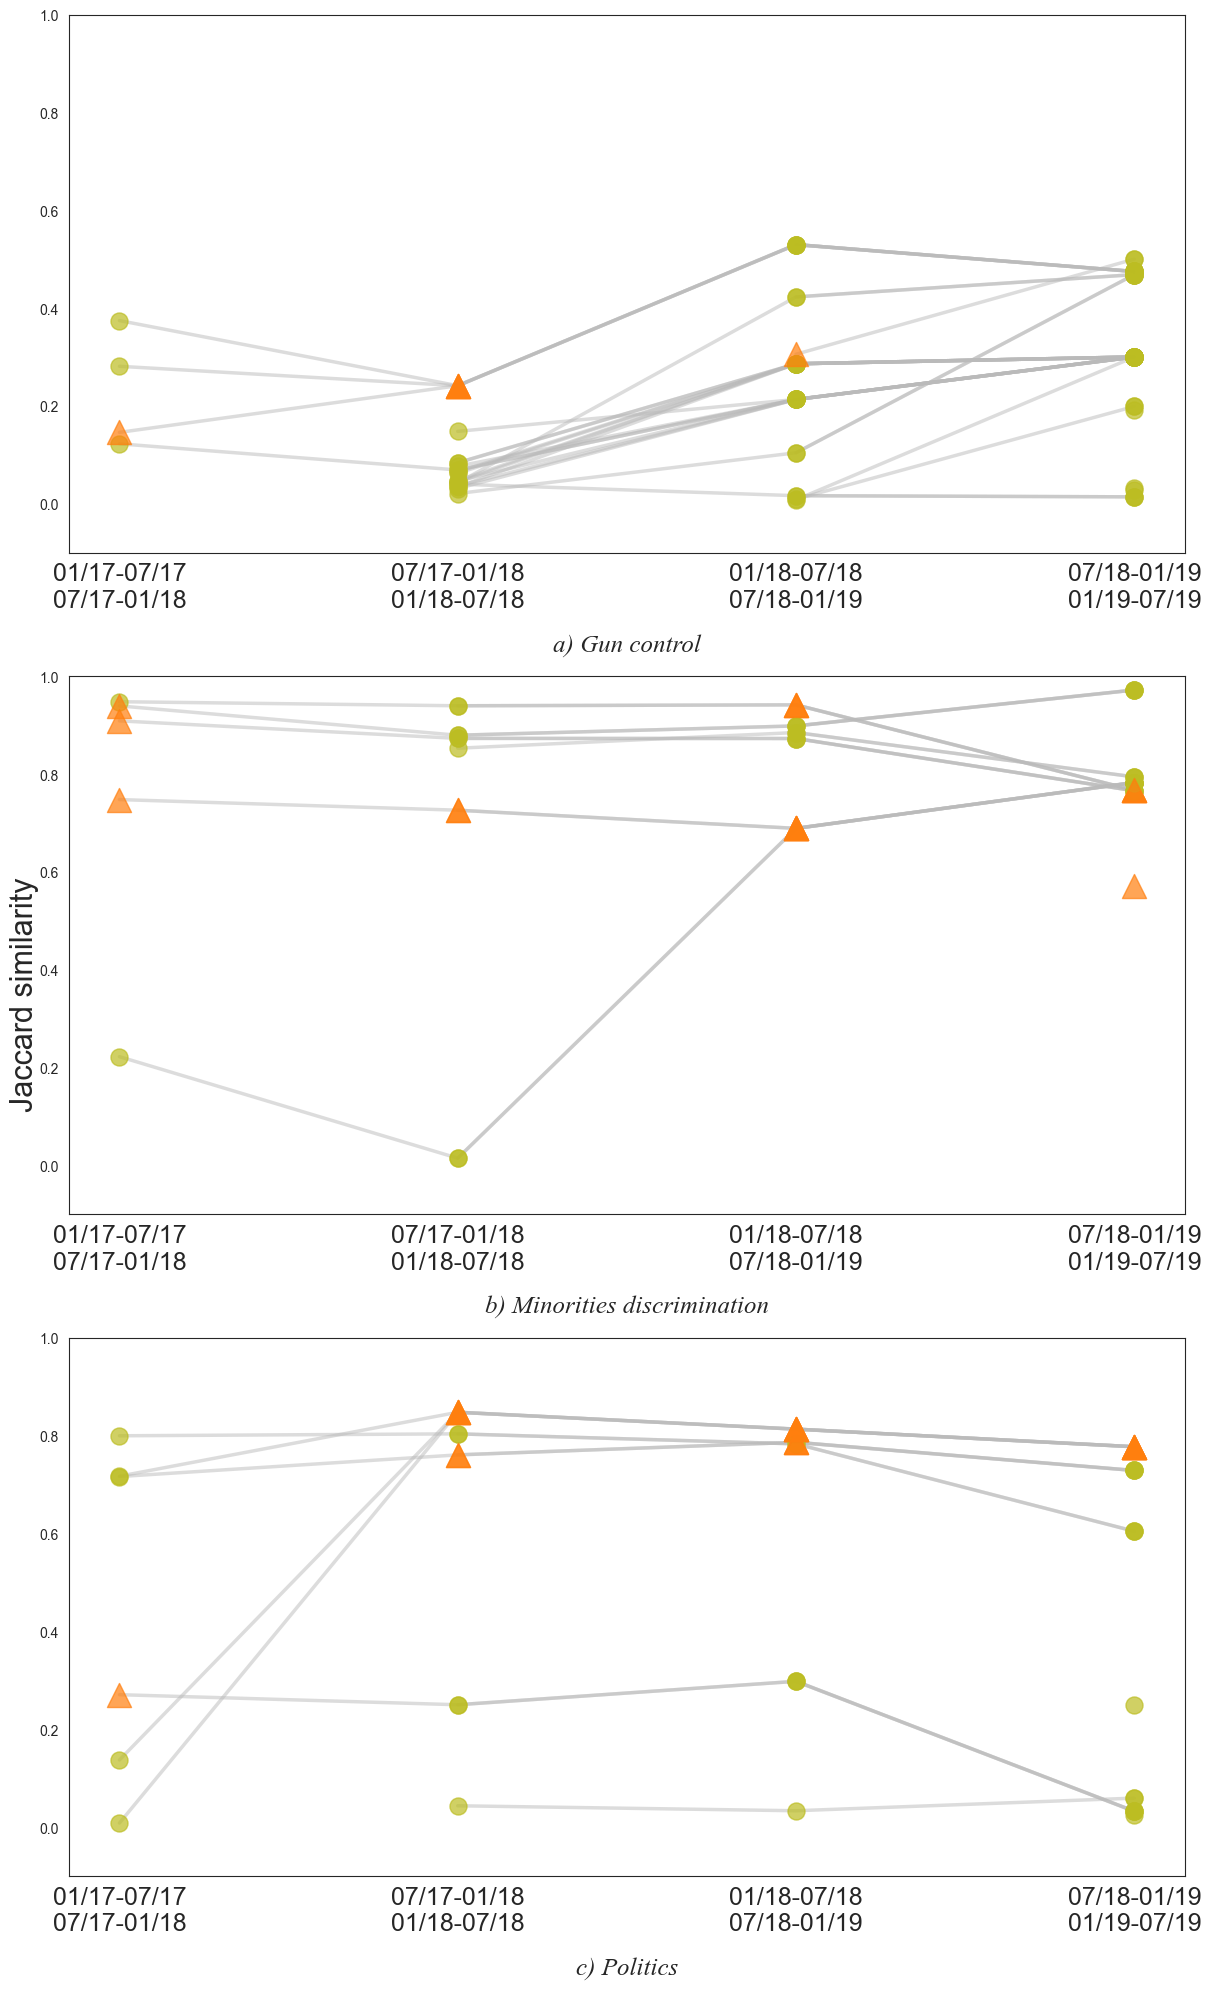

In [112]:
unique_plot_stability(categories, "not_EC")